<a href="https://colab.research.google.com/github/reidnclark/MFDPRepo/blob/main/COM450A03_Final_Research_Fair_PoliticalPersuasion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

## **Data Analysis Research Fair**
### *Cooper L., Yoga K., Reid C.*

---


---

## Code Section) **:**

# Full code:

---

In [3]:
################################################################################################
### INSTALLS ###
################################################################################################
# !pip install mlxtend==0.22.0
################################################################################################
################################################################################################




################################################################################################
### LIBRARIES ###
################################################################################################
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score # ...
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


################################################################################################ Hello
################################################################################################




################################################################################################
### NOTEBOOK DISPLAY SETTINGS & OPTIONS ###
################################################################################################
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all rows
################################################################################################
################################################################################################




################################################################################################
### VARIABLES, DATA SETUP & BASIC STATISTICAL OVERVIEW ###
################################################################################################
# Establish df...
data = pd.read_csv("Voter-Persuasion.csv")
df = pd.DataFrame(data) # This is the ORIGINAL DF

# Basic Descriptive Stats...
# print(df.describe()) # This is a large summary of each variable's stats.
# print(df.info()) # This is a check of the counts for each variable. (All 10,000)
# df.head() # This is the first 5 (0-4) rows. Note, it's called, not printed, for legibility.
print('---------------------------------------------------------------------------------')
print('1) Counts of "MOVED_AD" (Y for moved in Democratic direction.)')
print('---------------------------------------------------------------------------------')
print(df['MOVED_AD'].value_counts())  # Check frequency of target variable values.
print('---------------------------------------------------------------------------------')


# Plot for MOVED_AD: Show counts of 1 and 0 in a bar chart
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='MOVED_AD', palette='viridis')
plt.title('Distribution of MOVED_AD (1 = Moved, 0 = Not Moved)', fontsize=14)
plt.xlabel('MOVED_AD', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['0 (Not Moved)', '1 (Moved)'])
plt.show()

# Plot for Partition by MOVED_AD: Show counts of Y and N within each MOVED_AD value (1 and 0)
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='MOVED_AD', hue='Partition', palette='viridis')
plt.title('Partition Distribution within MOVED_AD', fontsize=14)
plt.xlabel('MOVED_AD', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['0 (Not Moved)', '1 (Moved)'])
plt.legend(title='Partition', loc='upper right', labels=['N (No Flyer)', 'Y (Flyer)'])
plt.show()
################################################################################################
################################################################################################




################################################################################################
### BINARY TRANSFORM FOR TARGET VARIABLE 'MOVED_AD' ###
################################################################################################
df['MOVED_AD'] = df['MOVED_AD'].apply(lambda x: 1 if x == 'Y' else 0)  # Convert 'Y'/'N' to 1/0
################################################################################################
################################################################################################




################################################################################################
### BASIC STATISTICAL OVERVIEW FOR PARTITIONED DATA... ###
### ...(Flyer Recipient = 'T' (treatment), No Flyer = 'V' (voter (untreated), control)... ###
### ... 'T' = 0, 'V' = 1 ###
################################################################################################
# Group by Partition and calculate basic descriptive statistics
grouped = df.groupby('Partition')['MOVED_AD'].agg(
    mean='mean',        # Proportion of moved voters
    count='count',      # Number of observations in each group
    std='std'           # Standard deviation of moved voters
).reset_index()

# Calculate the Standard Error (SE) of the mean for each group
grouped['se'] = grouped['std'] / np.sqrt(grouped['count'])

# Calculate the 95% Confidence Interval for the proportion of moved voters
confidence_level = 0.95
z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)  # Z-score for 95% confidence

grouped['ci_lower'] = grouped['mean'] - z_score * grouped['se']
grouped['ci_upper'] = grouped['mean'] + z_score * grouped['se']

# Print the descriptive statistics including CI
print('2) Summary of "Partition" (Recall: T = Flyer, V = No Flyer.)')
print('---------------------------------------------------------------------------------')
print(grouped)
# This will give us the mean (proportion of moved voters) in each group (Flyer vs No Flyer)
print('---------------------------------------------------------------------------------')

# Re-assert treated and control. Print legible statistics...
treated = df[df['Partition'] == 'T']['MOVED_AD']
control = df[df['Partition'] == 'V']['MOVED_AD']
# Calculate the proportions for treated and control groups
treated_mean = treated.mean()
control_mean = control.mean()

print(f"Proportion of moved voters (Treatment): {treated_mean*100:.4f} %")
print(f"Proportion of moved voters (Control): {control_mean*100:.4f} %")
print('---------------------------------------------------------------------------------')
################################################################################################
################################################################################################




################################################################################################
### RE-SAMPLE IMBALANCED SAMPLE SIZES USING BOOTSTRAPPING ###
################################################################################################
# Number of bootstrap iterations
n_iterations = 5000
bootstrap_diffs = []

# Perform bootstrapping
for i in range(n_iterations):
    # Resample treatment and control groups with replacement
    treated_sample = treated.sample(n=len(control), replace=True)
    control_sample = control.sample(n=len(control), replace=True)

    # Calculate means for the resampled groups
    treated_mean_sample = treated_sample.mean()
    control_mean_sample = control_sample.mean()

    # Calculate the difference in means for this bootstrap sample
    bootstrap_diffs.append(treated_mean_sample - control_mean_sample)

# Convert list to numpy array for further analysis
bootstrap_diffs = np.array(bootstrap_diffs)

# Check summary statistics of bootstrap differences
bootstrap_mean = bootstrap_diffs.mean()
conf_interval = np.percentile(bootstrap_diffs, [2.5, 97.5])

# Print out results
print('3) Resample with replacement (Bootstrap)')
print('---------------------------------------------------------------------------------')
print(f"Raw Mean Difference: {(treated_mean - control_mean)*100:.4f} %")
print(f"Bootstrap Mean Difference: {bootstrap_mean*100:.4f} %")
print(f"Bootstrap 95% Confidence Interval: ({(conf_interval[0])*100:.4f} %, {(conf_interval[1]*100):.4f}) %")
print('---------------------------------------------------------------------------------')
################################################################################################
################################################################################################




################################################################################################
### PLOT BOOTSTRAPPED, PARTITIONED SAMPLE DATA ###
################################################################################################
# Set up the plot
plt.figure(figsize=(10, 6))
# Plot histogram using seaborn for better style
sns.histplot(bootstrap_diffs, kde=True, color='blue', bins=30)

# Add titles and labels
plt.title('Bootstrap Distribution of the Difference in Proportions', fontsize=16)
plt.xlabel('Difference in Proportions (Treatment - Control)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(bootstrap_mean, color='black', linestyle='--', label=f'Mean = {(bootstrap_mean*100):.2f}%')
plt.axvline(conf_interval[0], color='red', linestyle='--', label=f'95% CI (Lower) = {(conf_interval[0]*100):.2f}%')
plt.axvline(conf_interval[1], color='darkgreen', linestyle='--', label=f'95% CI (Upper) = {(conf_interval[1]*100):.2f}%')

# Show plot
plt.legend()
plt.show()
print('---------------------------------------------------------------------------------')
################################################################################################
################################################################################################




################################################################################################
### CONFIRM AVAILABLE PREDICTORS TO MODIFY DF, SINCE SOME IN DATADICT AREN'T IN CSV ###
################################################################################################
# Note: this updates the below with available predictors to account for an imbalanced ...
# ... data Dict vs. the actual CSV file.
available_predictors = [

    'OPP_SEX', 'AGE', 'HH_ND', 'HH_NR', 'HH_NI', 'MED_AGE', 'NH_WHITE', 'NH_AA',
    'NH_ASIAN', 'NH_MULT', 'HISP', 'COMM_LT10', 'COMM_609P', 'MED_HH_INC', 'COMM_CAR',
    'COMM_CP', 'COMM_PT', 'COMM_WALK', 'KIDS', 'M_MAR', 'F_MAR', 'ED_4COL', 'GENDER_F',
    'GENDER_M', 'H_AFDLN3P', 'H_F1', 'H_M1', 'H_MFDLN3P', 'PARTY_D', 'PARTY_I', 'PARTY_R',
    'VPP_08', 'VPP_12', 'VPR_08', 'VPR_10', 'VPR_12', 'VG_04', 'VG_06', 'VG_08', 'VG_10',
    'VG_12', 'PP_PELIG', 'PR_PELIG', 'AP_PELIG', 'G_PELIG', 'E_PELIG', 'NL5G', 'NL3PR',
    'NL5AP', 'NL2PP', 'REG_DAYS', 'UPSCALEBUY', 'UPSCALEMAL', 'UPSCALEFEM', 'BOOKBUYERI',
    'FAMILYMAGA', 'FEMALEORIE', 'RELIGIOUSM', 'GARDENINGM', 'CULINARYIN', 'HEALTHFITN',
    'DOITYOURSE', 'FINANCIALM', 'RELIGIOUSC', 'POLITICALC', 'MEDIANEDUC', 'MESSAGE_A',
    # Add in the target variable column (MOVED_AD), as well as the Partition column...
    # We don't need partition right now, but it lets us use it later without modifying df..
    'MOVED_AD', 'Partition'
]

df_predictors = data[available_predictors]

print("Updated DF with Predictor Variables only (df head, description):")
print('---------------------------------------------------------------------------------')

print(df_predictors.head()) # More elementary statistical summaries again.
print(df_predictors.describe()) # Ditto above.
################################################################################################
################################################################################################




################################################################################################
### EXPLORE VARIABLES' PREDICTIVE POTENTIAL USING A (TUNED) RANDOM FOREST... ###
### ... Since there may exist complex interactions between the large DataDict... ###
### ... We can start with a random forest, and later compare with a LogReg to... ###
### ... Check. It may be more simple, like linear relationships between the... ###
### ... Age, Gender, Number of people in house, etc. ###
################################################################################################
# Thorough Params:
# # Define the grid of hyperparameters
# param_grid = {
#     'n_estimators': [50, 50], # of trees in forest. 3 tests
#     'max_depth': [10, 20], # for each tree (e.g., 10), specify depth
#     'min_samples_split': [3, 5], # split a node if at least 'n' many samples in a node
#     'min_samples_leaf': [3, 5],
#     'max_features': ['sqrt'],
#     'criterion': ['gini']
# }

# Quick Params:
# # Define the grid of hyperparameters
param_grid = {
    'n_estimators': [30, 50], # of trees in forest. 3 tests
    'max_depth': [10, 20], # for each tree (e.g., 10), specify depth
    'min_samples_split': [3, 5], # split a node if at least 'n' many samples in a node
    'min_samples_leaf': [3, 5],
    'max_features': ['sqrt'],
    'criterion': ['gini']
}

# Create the predictors DataFrame
df_predictors = df[available_predictors]

# Handle categorical variables: Use LabelEncoder to convert categorical variables to numeric values
label_encoders = {}
for column in df_predictors.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_predictors.loc[:, column] = le.fit_transform(df_predictors[column])
    label_encoders[column] = le

# Split the data into features (X) and target (y)
X = df_predictors.drop(columns=['MOVED_AD', 'Partition'])  # Exclude the target and Partition column
y = df_predictors['MOVED_AD']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with 4-fold cross-validation (cross validation)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=4, n_jobs=1, verbose=0)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the model on the test set
test_score = best_rf_model.score(X_test, y_test)
print(f"Test accuracy: {test_score:.4f}")

# Optionally, display feature importances from the best model
feature_importances = best_rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from Random Forest')
plt.show()

# Extract feature importances from the best Random Forest model
feature_importances = best_rf_model.feature_importances_

# Create a DataFrame with features and their importance values
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order and select the top 20 features
top_20_features = importance_df.sort_values(by='Importance', ascending=False).head(20)['Feature'].tolist()

# Subset the df_predictors DataFrame to include only the top 10 important features
df_top_20 = df[top_20_features]

print("Top 20 Important Features:")
print(importance_df.sort_values(by='Importance', ascending=False).head(20)) # Print the top 10
################################################################################################
################################################################################################




################################################################################################
### PLOT CORRELATION MATRIX TO CONFIRM NO UNEXPECTED BEHAVIOUR IN MOST-RELEVANT PREDICTORS ###
################################################################################################
# Calculate the correlation matrix for the top 20 features
correlation_matrix_top_20 = df_top_20.corr()

print(correlation_matrix_top_20)

# Optionally, visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_top_20, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation Matrix for Top 10 Important Features', fontsize=16)
plt.show() # This line of code will plot the corr-matr. Though, it is, in fact, confirmed.
################################################################################################
################################################################################################




################################################################################################
### DROP FEATURES WITH CORRELATION GREATER THAN 0.80 TO AVOID REDUNDANCY IN MODEL FITTING ###
################################################################################################
# Drop columns that are highly correlated (greater than 0.8 correlation) in the df_top_20 dataset
correlation_matrix_top_20 = df_top_20.corr()

# Find pairs of features with correlation greater than 0.8 and drop one of each pair
correlation_threshold = 0.8
to_drop = set()  # A set to store columns to drop

for i in range(len(correlation_matrix_top_20.columns)):
    for j in range(i):
        if abs(correlation_matrix_top_20.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix_top_20.columns[i]
            to_drop.add(colname)

# Drop the columns that are highly correlated
df_top_20_reduced = df_top_20.drop(columns=to_drop)

# Print out the features that were dropped
print(f"Features dropped due to high correlation (above {correlation_threshold}): {to_drop}")

# Recompute the correlation matrix for the remaining features
correlation_matrix_top_20_reduced = df_top_20_reduced.corr()

# Print and visualize the updated correlation matrix
print(correlation_matrix_top_20_reduced)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_top_20_reduced, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Updated Correlation Matrix for Remaining Features')
plt.show()
################################################################################################
################################################################################################




################################################################################################
### UPDATE RANDOM FOREST, REDO ###
################################################################################################
# Drop the features that were identified as highly correlated
dropped_features = {'NH_AA', 'VG_12', 'NL5G', 'GENDER_F', 'G_PELIG'}

# Remove those dropped features from the df_top_20 DataFrame
df_top_20_reduced = df_top_20.drop(columns=dropped_features)

# Prepare the final dataset for model training, using only the top features # << ADDED
X_reduced_new = df_top_20_reduced  # Using the reduced features after dropping high correlations

# Split the data into training and test sets # << ADDED
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_reduced_new, y, test_size=0.3, random_state=42)

# Recompute the feature importances from the best Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_new, y_train_new) # << CHANGED: y_train to y_train_new

# Get the new feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame with features and their importance values
importance_df = pd.DataFrame({
    'Feature': X_train_new.columns,  # Use X_train_new.columns instead of df_top_20_reduced.columns
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order and select the top 20 features
top_20_features_new = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Print the updated Top 20 important features
print("Updated Top 20 Important Features after removing correlated features:")
print(top_20_features_new)
print('---------------------------------------------------------------------------------')
################################################################################################
################################################################################################



################################################################################################
### UPDATED RANDOM FOREST EVALUATION ###
################################################################################################
# Prepare the final dataset for model training, using only the top features
X_reduced_new = df_top_20_reduced  # Using the reduced features after dropping high correlations

# Split the data into training and test sets
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_reduced_new, y, test_size=0.3, random_state=42)

# Standardize the data (important for models like SVM and Logistic Regression)
scaler_new = StandardScaler()
X_train_scaled_new = scaler_new.fit_transform(X_train_new)
X_test_scaled_new = scaler_new.transform(X_test_new)

# Initialize and train the updated Random Forest model
rf_model_new = RandomForestClassifier(random_state=42)
rf_model_new.fit(X_train_new, y_train_new)

# Evaluate the updated model on the test set
evaluate_model(rf_model_new, X_test_new, y_test_new, "Updated Random Forest")
################################################################################################
################################################################################################




################################################################################################
### PREDICTIVE MODELS (Random Forest, Logistic Regression, SVM, Gradient Boosting) ###
################################################################################################

# Prepare the final reduced dataset for model training
X_reduced = df_top_20_reduced  # Using only the reduced features after dropping high correlations
y = df['MOVED_AD']  # The target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

# Standardize the data (important for models like SVM and Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the models

# 2) Logistic Regression
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train_scaled, y_train)


# Updated evaluation function with more advanced metrics
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluates the model and prints its performance."""
    # Predictions on test set
    y_pred = model.predict(X_test)

    # Accuracy on the test set
    accuracy = accuracy_score(y_test, y_pred)

    # Precision, Recall, F1 Score
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Print performance
    print(f"--------------------------------------------------")
    print(f"Performance of {model_name}:")
    print(f"--------------------------------------------------")
    print(f"Accuracy on Test Set: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"--------------------------------------------------")

# Evaluate all models using the full test set (X_test)
evaluate_model(logreg_model, X_test_scaled, y_test, "Logistic Regression")
################################################################################################
################################################################################################



################################################################################################
### PREDICT PROPENSITIES FOR FIRST THREE RECORDS IN THE VALIDATION SET ###
################################################################################################

# Get the predicted probabilities for the test set
propensities = rf_model_new.predict_proba(X_test_new)

# Get the predicted classes
predictions = rf_model_new.predict(X_test_new)

# Print the predicted probabilities for the first 3 records
print('---------------------------------------------------------------------------------')
print("Predicted Propensities and Actual for the First 3 Records in the Validation Set:")
print('---------------------------------------------------------------------------------')
for i in range(10):
    actual = "Moved" if y_test_new.iloc[i] == 1 else "Not Moved"  # Actual result
    predicted = "Moved" if predictions[i] == 1 else "Not Moved"  # Predicted result
    prop_moved = propensities[i][1]  # Probability for "Moved"
    prop_not_moved = propensities[i][0]  # Probability for "Not Moved"

    print(f"Record {i+1}:")
    print(f"  Actual: {actual}")
    print(f"  Predicted: {predicted}")
    print(f"  Propensity for Moved: {prop_moved:.4f}")
    print(f"  Propensity for Not Moved: {prop_not_moved:.4f}")
    print('---------------------------------------------------------------------------------')


################################################################################################
################################################################################################




################################################################################################
### FLYER REVERSED SCENARIO ###
################################################################################################
# Step 1: Create the 'Flyer-reversed' variable
df['Flyer-reversed'] = df['Partition'].apply(lambda x: 'V' if x == 'T' else 'T')

# Step 2: Update the predictors dataset with the 'Flyer-reversed' column
df_predictors_reversed = df.copy()

# We will now replace the 'Partition' column with 'Flyer-reversed'
df_predictors_reversed['Partition'] = df_predictors_reversed['Flyer-reversed']

# Step 3: Prepare the final dataset (remove unnecessary columns and apply the same preprocessing as before)
X_reduced_reversed = df_predictors_reversed[top_20_features_new['Feature']]  # Select only the top 20 features

# We will now replace the 'Partition' column with 'Flyer-reversed'
X_reduced_reversed['Partition'] = df_predictors_reversed['Flyer-reversed']

# Convert categorical variables to numeric values for top 20
label_encoders = {}
for column in X_reduced_reversed.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_reduced_reversed.loc[:, column] = le.fit_transform(X_reduced_reversed[column])
    label_encoders[column] = le


# One-hot encode 'Partition' before scaling
X_reduced_reversed = pd.get_dummies(X_reduced_reversed, columns=['Partition'], drop_first=True) # One-hot encode 'Partition'

# Now standardize
scaler_reversed = StandardScaler()
X_reduced_scaled_reversed = scaler_reversed.fit_transform(X_reduced_reversed)

# Split the data into training and test sets
X_train_reversed, X_test_reversed, y_train_reversed, y_test_reversed = train_test_split(X_reduced_scaled_reversed, y, test_size=0.3, random_state=42)

# Step 4: Train the Random Forest model using 'Flyer-reversed' instead of 'Flyer'
rf_model_reversed = RandomForestClassifier(random_state=42)
rf_model_reversed.fit(X_train_reversed, y_train_reversed)

# Step 5: Get the predicted probabilities for the test set
propensities_reversed = rf_model_reversed.predict_proba(X_test_reversed)

# Step 6: Print the predicted probabilities for the first 10 records in the validation set
print('---------------------------------------------------------------------------------')
print("Predicted Propensities and Actual Movement for the First 10 Records in the Validation Set (Flyer-reversed):")
print('---------------------------------------------------------------------------------')
for i in range(10):
    # Get the predicted class (0 for Not Moved, 1 for Moved)
    predicted_class = rf_model_reversed.predict(X_test_reversed[i].reshape(1, -1))[0]

    # Format the output using f-strings
    prop_moved = propensities_reversed[i][1]  # Probability of class 1 (Moved)
    prop_not_moved = propensities_reversed[i][0]  # Probability of class 0 (Not Moved)

    # Map the predicted class to its label
    prediction_label = "Moved" if predicted_class == 1 else "Not Moved"

    # Get the actual class from y_test_reversed (1 for Moved, 0 for Not Moved)
    actual_class = "Moved" if y_test_reversed.iloc[i] == 1 else "Not Moved"

    # Print the results for the record
    print(f"Record {i+1}:")
    print(f"  Actual: {actual_class}")
    print(f"  Predicted Class: {prediction_label}")
    print(f"  Propensity for Moved: {prop_moved:.4f}")
    print(f"  Propensity for Not Moved: {prop_not_moved:.4f}")
    print('---------------------------------------------------------------------------------')
################################################################################################
################################################################################################




################################################################################################
### UPLFIT ###
################################################################################################
# Get the predicted probabilities for the test set when Flyer = 1 (rf_model_new) and Flyer = 0 (rf_model_reversed)
propensities_flyer_1 = rf_model_new.predict_proba(X_test_new)
propensities_flyer_0 = rf_model_reversed.predict_proba(X_test_reversed)

# Calculate the uplift for the first three records
print('---------------------------------------------------------------------------------')
print("Uplift for the First 10 Records in the Validation Set:")
print('---------------------------------------------------------------------------------')

for i in range(10):
    # Probability of success (Moved) for Flyer = 1 (rf_model_new)
    prob_success_flyer_1 = propensities_flyer_1[i][1]

    # Probability of success (Moved) for Flyer = 0 (rf_model_reversed)
    prob_success_flyer_0 = propensities_flyer_0[i][1]

    # Calculate the uplift
    uplift = prob_success_flyer_1 - prob_success_flyer_0

    print(f"Record {i+1}:")
    print(f"  Probability for Flyer = 1 (Moved): {prob_success_flyer_1:.4f}")
    print(f"  Probability for Flyer = 0 (Moved): {prob_success_flyer_0:.4f}")
    print(f"  Uplift: {uplift:.4f}")
    print('---------------------------------------------------------------------------------')
################################################################################################
################################################################################################



################################################################################################
### UPLIFT CUTOFF CALCULATION AND SELECTION OF TOP 10% VOTERS BASED ON UPLIFT ###
################################################################################################

# Assuming you already have the 'uplift' values computed for each voter
# You can use the `propensities` for both "Flyer = 1" and "Flyer = 0" to compute uplift for each record

# Calculate uplift for each voter (difference between the probabilities)
uplift = propensities[:, 1] - propensities[:, 0]  # P(success | Flyer = 1) - P(success | Flyer = 0)

# Step 1: Sort the uplift values in descending order (from highest uplift to lowest)
sorted_uplifts = np.sort(uplift)[::-1]

# Step 2: Calculate the index for top 10% of voters
top_10_percent_index = int(len(sorted_uplifts) * 0.1)

# Step 3: Identify the uplift cutoff (the value at the 10th percentile)
uplift_cutoff = sorted_uplifts[top_10_percent_index - 1]  # Python uses zero-indexing, so subtract 1

# Step 4: Select the top 10% voters based on uplift
# Create a mask to identify voters whose uplift is greater than or equal to the cutoff
top_voters_mask = uplift >= uplift_cutoff

# Step 5: Filter the records that should receive the flyer (top 10% based on uplift)
top_voters = X_test_new[top_voters_mask]
top_voters_actual = y_test_new.iloc[top_voters_mask]  # Actual outcomes for the top voters

# Step 6: Report the uplift values for the first 3 records in the top 10% selection
print('---------------------------------------------------------------------------------')
print("Uplift for the First 3 Records in the Top 10% Selection:")
print('---------------------------------------------------------------------------------')
# Fix the issue by using NumPy array indexing instead of .iloc
for i in range(min(3, len(top_voters))):  # Show up to the first 3 records
    actual = "Moved" if top_voters_actual.iloc[i] == 1 else "Not Moved"
    uplift_value = uplift[top_voters_mask][i]  # Use array indexing directly

    print(f"Record {i+1}:")
    print(f"  Actual: {actual}")
    print(f"  Uplift: {uplift_value:.4f}")
    print('---------------------------------------------------------------------------------')

# Optional: Print the uplift cutoff for reference
print(f"Uplift cutoff value for top 10% selection: {uplift_cutoff:.4f}")
################################################################################################
################################################################################################

################################################################################################
### UPLFIT CUTOFF CALCULATION AND SELECTION OF TOP 10% VOTERS BASED ON UPLIFT ###
################################################################################################

# Assuming you already have the 'uplift' values computed for each voter
# You can use the `propensities` for both "Flyer = 1" and "Flyer = 0" to compute uplift for each record

# Calculate uplift for each voter (difference between the probabilities)
uplift = propensities[:, 1] - propensities[:, 0]  # P(success | Flyer = 1) - P(success | Flyer = 0)

# Create a new column in your DataFrame to store the uplift values
X_test_new['uplift'] = uplift

# Step 1: Sort the dataset by uplift in descending order (from highest uplift to lowest)
sorted_df = X_test_new.sort_values(by=['uplift'], ascending=False)  # Sort by the 'uplift' column

# Step 2: Calculate number of records for top 10%
top_10_percent_count = int(len(sorted_df) * 0.10)

# Step 3: Select the top 10% based on uplift score
top_10_percent_uplift = sorted_df.head(top_10_percent_count)

# Step 4: Print the top 10% uplift scores
print("Top 10% Uplift Scores:")
print(top_10_percent_uplift[['uplift']])  # Print the 'uplift' column



FileNotFoundError: [Errno 2] No such file or directory: 'Voter-Persuasion.csv'

In [ ]:
import pandas as pd

# Assuming df already contains the necessary columns 'REG_DAYS', 'MOVED_AD', and 'Partition'

# Discretize REG_DAYS into bins (adjust these bins as needed)
reg_days_bins = [0, 30, 60, 90, 180, 365, 730, 1000]  # Example bins: 0-30 days, 30-60 days, etc.
reg_days_labels = ['0-30', '31-60', '61-90', '91-180', '181-365', '366-730', '730+']
df['REG_DAYS_GROUP'] = pd.cut(df['REG_DAYS'], bins=reg_days_bins, labels=reg_days_labels)

# Calculate the conversion rate (mean of MOVED_AD) for each REG_DAYS_GROUP and Partition
reg_days_partition_conversion = df.groupby(['REG_DAYS_GROUP', 'Partition'])['MOVED_AD'].mean().reset_index()

# Display the resulting dataframe in the requested format
print(reg_days_partition_conversion)


   REG_DAYS_GROUP Partition  MOVED_AD
0            0-30         T       NaN
1            0-30         V       NaN
2           31-60         T  0.000000
3           31-60         V       NaN
4           61-90         T  0.500000
5           61-90         V  0.166667
6          91-180         T  0.428571
7          91-180         V  0.166667
8         181-365         T  0.360360
9         181-365         V  0.311828
10        366-730         T  0.441913
11        366-730         V  0.404110
12           730+         T  0.487952
13           730+         V  0.418033


<ipython-input-29-9ea411d2a71e>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reg_days_partition_conversion = df.groupby(['REG_DAYS_GROUP', 'Partition'])['MOVED_AD'].mean().reset_index()


<ipython-input-30-777f22d1e257>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_partition_reg_days = df.groupby(['AGE_GROUP', 'Partition'])['REG_DAYS'].mean().reset_index()


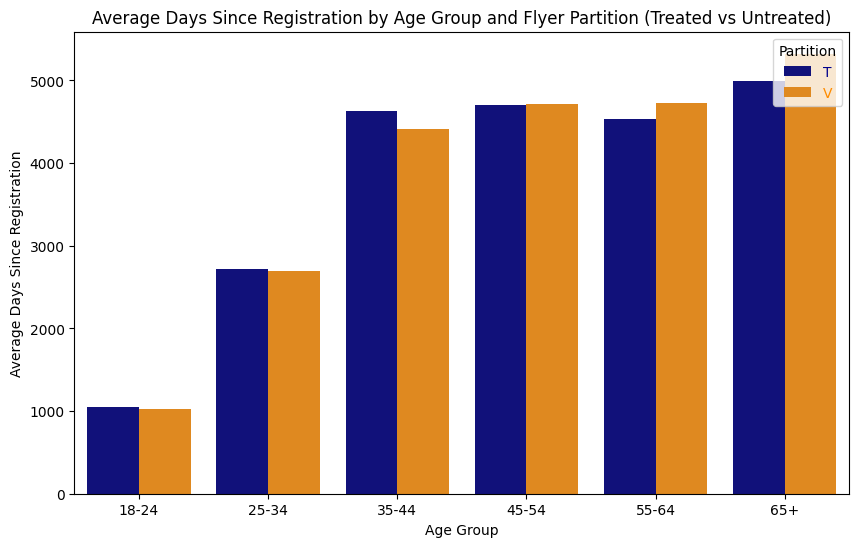

   AGE_GROUP Partition     REG_DAYS
0      18-24         T  1051.725061
1      18-24         V  1026.327526
2      25-34         T  2714.808219
3      25-34         V  2697.369309
4      35-44         T  4633.870330
5      35-44         V  4415.758454
6      45-54         T  4702.497297
7      45-54         V  4716.009126
8      55-64         T  4538.636697
9      55-64         V  4726.281421
10       65+         T  4990.104124
11       65+         V  5322.847676


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df contains 'AGE', 'REG_DAYS', and 'Partition' columns

# Create Age Groups (you can adjust the bins based on your business needs)
age_bins = [18, 24, 34, 44, 54, 64, 100]
age_labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=age_bins, labels=age_labels)

# Calculate the average REG_DAYS for each Age Group, split by Partition (Treated vs Untreated)
age_partition_reg_days = df.groupby(['AGE_GROUP', 'Partition'])['REG_DAYS'].mean().reset_index()

# Set custom color palette for the Partition (Treated vs Untreated)
palette = {'T': 'darkblue', 'V': 'darkorange'}  # Map 'T' to darkblue and 'V' to darkorange

# Plot the average REG_DAYS for each Age Group, split by Partition
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='AGE_GROUP', y='REG_DAYS', hue='Partition', data=age_partition_reg_days, palette=palette)

# Add labels and title
plt.title('Average Days Since Registration by Age Group and Flyer Partition (Treated vs Untreated)')
plt.ylabel('Average Days Since Registration')
plt.xlabel('Age Group')

# Add color-coded legend with custom text color
legend = plt.legend(title='Partition', loc='upper right')

# Change the text color of the legend labels
for text, label in zip(legend.texts, ['Untreated', 'Treated']):
    if label == 'Untreated':
        text.set_color('darkblue')  # Dark orange for Untreated
    else:
        text.set_color('darkorange')  # Dark blue for Treated

# Show the plot
plt.show()

# Print out the average REG_DAYS for further analysis
print(age_partition_reg_days)


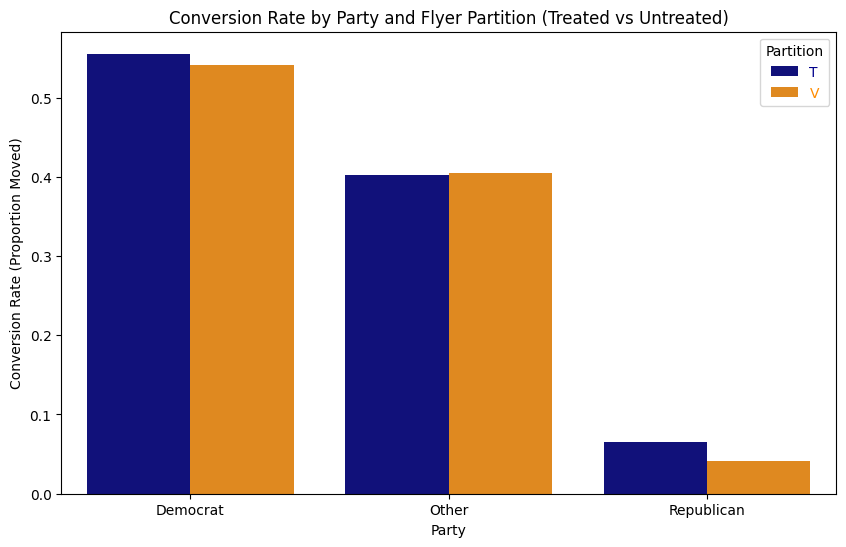

        Party Partition  MOVED_AD
0    Democrat         T  0.555358
1    Democrat         V  0.540848
2       Other         T  0.402490
3       Other         V  0.404812
4  Republican         T  0.065564
5  Republican         V  0.041308


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df contains 'PARTY_R', 'PARTY_D', 'MOVED_AD', and 'Partition' columns

# Combine Republican and Democrat party membership into a single column for easy plotting
df['Party'] = df.apply(lambda row: 'Republican' if row['PARTY_R'] == 1 else ('Democrat' if row['PARTY_D'] == 1 else 'Other'), axis=1)

# Calculate the conversion rate for each Party, split by Partition (Treated vs Untreated)
party_partition_conversion = df.groupby(['Party', 'Partition'])['MOVED_AD'].mean().reset_index()

# Set custom color palette for the Partition (Treated vs Untreated)
palette = {'T': 'darkblue', 'V': 'darkorange'}  # Map 'T' to darkblue and 'V' to darkorange

# Plot the conversion rate for each party, split by Partition
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Party', y='MOVED_AD', hue='Partition', data=party_partition_conversion, palette=palette)

# Add labels and title
plt.title('Conversion Rate by Party and Flyer Partition (Treated vs Untreated)')
plt.ylabel('Conversion Rate (Proportion Moved)')
plt.xlabel('Party')

# Add color-coded legend with custom text color
legend = plt.legend(title='Partition', loc='upper right')

# Change the text color of the legend labels
for text, label in zip(legend.texts, ['Untreated', 'Treated']):
    if label == 'Untreated':
        text.set_color('darkblue')  # Dark blue for Untreated
    else:
        text.set_color('darkorange')  # Dark orange for Treated

# Show the plot
plt.show()

# Print out the conversion rates for further analysis
print(party_partition_conversion)
